### To begin, we import the necessary Python packages

I use the `pyMCR` and the `pyfftw` package. To install it run:
```
conda install -c conda-forge pymcr pyfftw
```
Install `matplotlib-scalebar` as
```
pip install matplotlib-scalebar
```

In [1]:
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import gridspec as mpgs
import numpy as np
import scipy as sp
import matplotlib as mpl
from skimage import transform as skt
import os
import time
import multiprocessing as mp
import skimage.filters as skf
from scipy import ndimage as scnd
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib_scalebar.scalebar import SI_LENGTH_RECIPROCAL
from matplotlib.offsetbox import AnchoredText
import math
import sys
import numba
import pyfftw
import pymcr
%matplotlib inline
plt.rcParams['image.cmap'] = 'magma'
plt.rcParams.update({'font.size': 25})
plt.rcParams.update({'font.weight': 'bold'})
plt.rcParams.update({'figure.autolayout': True})

Download the source code as
```
cd
sudo mkdir Codes
cd Codes
git clone https://github.com/dxm447/stemtools.git
```

In [2]:
import sys
sys.path.append('/home/cades/Codes/stemtools')
import stemtools as st
%load_ext autoreload
%autoreload 2

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from matplotlib.colors import LinearSegmentedColormap as LSC
vl_cl = LSC.from_list('list', [(0, 0, 0), (0.557,0.267, 0.678),(1,1,1)], N=256)
bu_cl = LSC.from_list('list', [(0, 0, 0), (0.161,0.502, 0.725),(1,1,1)], N=256)
gr_cl = LSC.from_list('list', [(0, 0, 0), (0.153,0.682, 0.376),(1,1,1)], N=256)
yl_cl = LSC.from_list('list', [(0, 0, 0), (0.945,0.769, 0.059),(1,1,1)], N=256)
or_cl = LSC.from_list('list', [(0, 0, 0), (0.902,0.494, 0.133),(1,1,1)], N=256)
rd_cl = LSC.from_list('list', [(0, 0, 0), (0.906,0.298, 0.235),(1,1,1)], N=256)
lin_burd = LSC.from_list('list', [(0, 35/255, 156/255), (0.95,0.95, 0.95),(249/255,56/255,34/255)], N=256)

Add the directory path to where your 4D data lies

In [5]:
dir_path = "/home/cades/Data4D_2/Debangshu/Core@Shell NBED/Nion Swift Library 20190810 - EH-83-I Rh@Pt Thick/"

Then we go to the folder where our data is stored, and load the 4D data

In [6]:
retval = os.getcwd()
os.chdir(dir_path)

In [7]:
st.tic()
strain4D = np.load('Particle1_4DSTEM.npy')
json4D = 'Particle1_4DSTEM.json'
simulADF = np.load('Particle1_4DSTEM_ADF.npy')
jsonADF = 'Particle1_4DSTEM_ADF.json'
with open(json4D) as json_4D:
    info4D = json.load(json_4D)
with open(jsonADF) as json_ADF:
    infoADF = json.load(json_ADF)
st.toc()

Elapsed time: 7.094093 seconds.



In [8]:
strain4D = np.transpose(strain4D,(2,3,0,1))

To do the calculations it is significantly easier to transpose the datasets. Normally both NION and Titan generates data in the format of [ScanY,ScanX,DiffQ,DiffP] where Scan refers to the real dimensions and Diff refers to the Fourier dimensions and [P,Q] are the Fourier coordinates of [X,Y]. However, we transpose our data to be of the form [DiffQ,DiffP,ScanY,ScanX]

In [9]:
strain4D.shape

(360, 360, 200, 200)

In [10]:
scan_calib_vals = infoADF['spatial_calibrations'][0]['scale']
scan_calib_unit = infoADF['spatial_calibrations'][0]['units']

Check the synthetic BF-STEM image to see whether there are any issues with scan errors

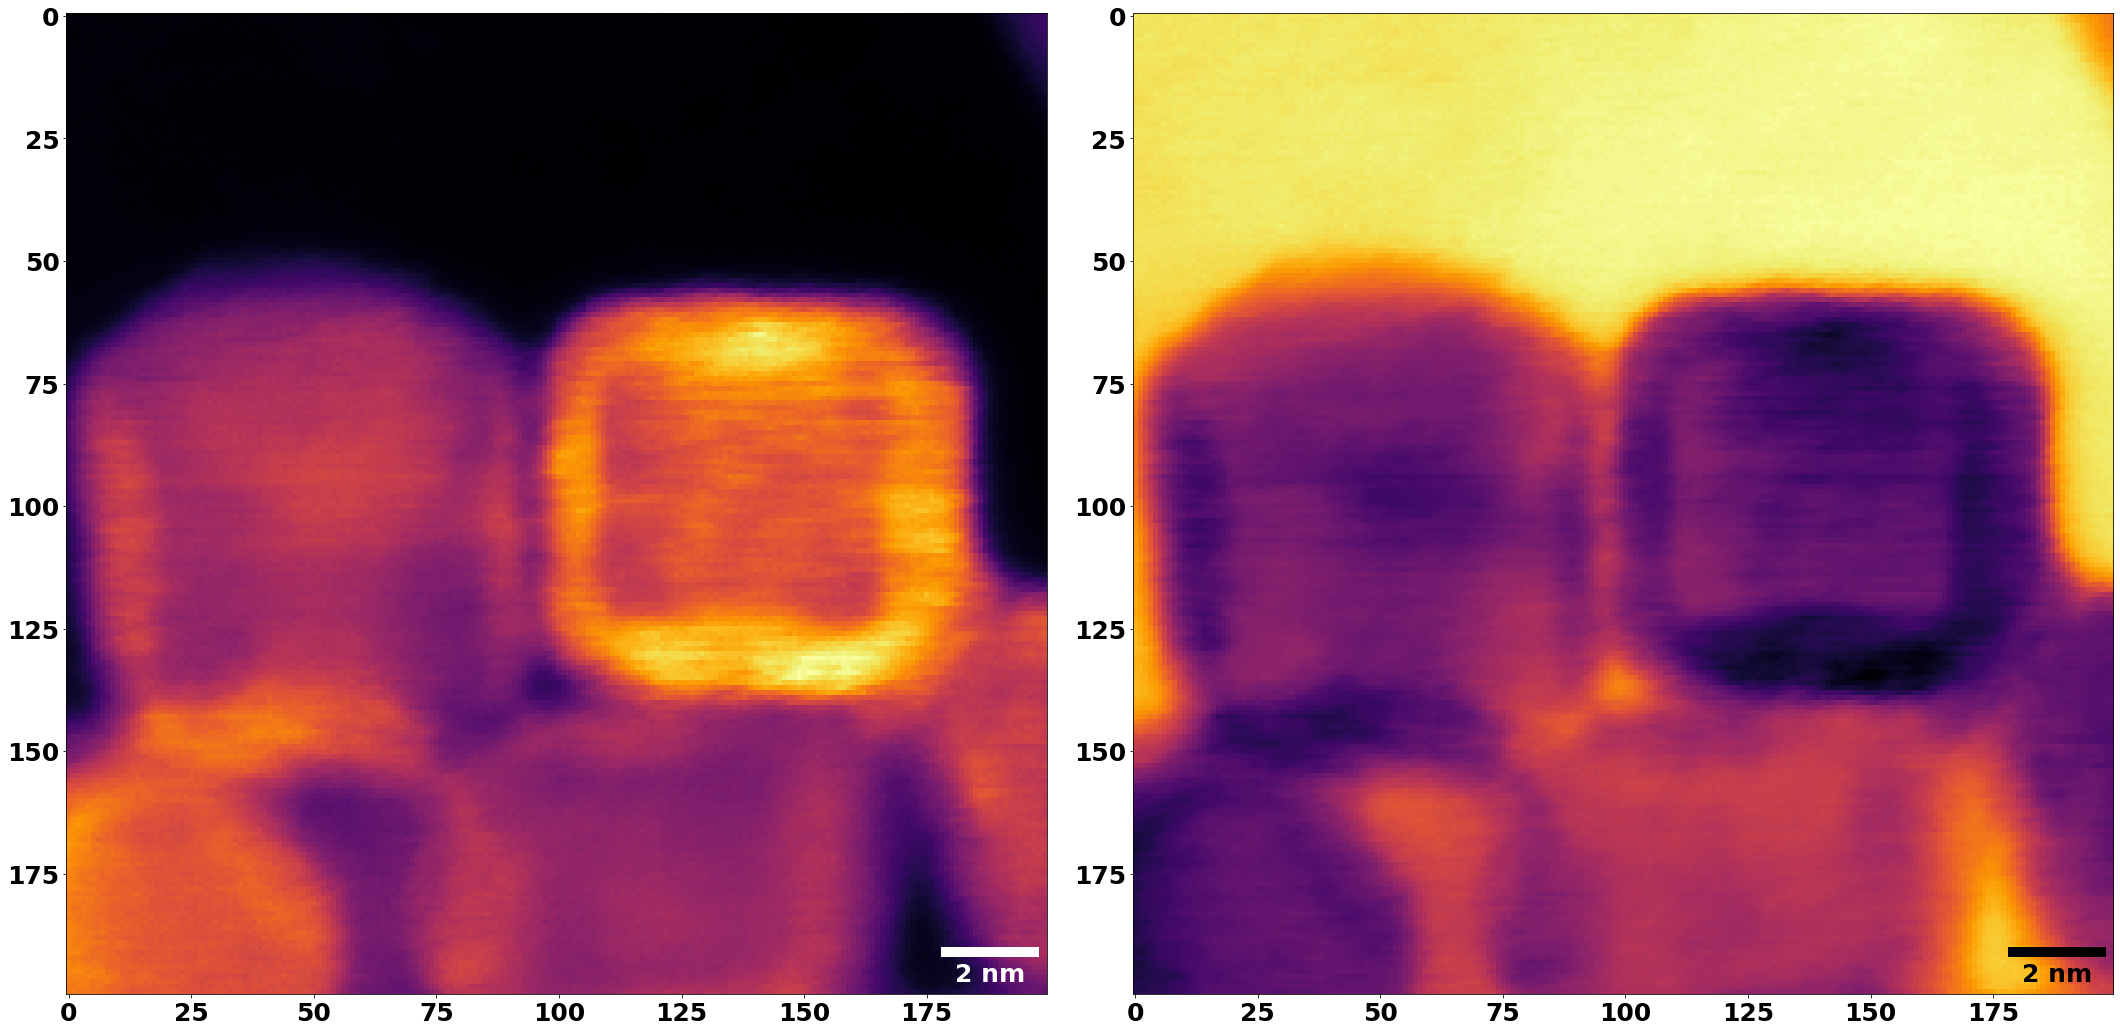

In [11]:
bf_stem = np.sum(strain4D,axis=(0,1))
plt.figure(figsize=(30,15))
plt.subplot(1,2,1)
plt.imshow(simulADF,cmap='inferno')
scalebar = ScaleBar(scan_calib_vals,scan_calib_unit)
scalebar.location = 'lower right'
scalebar.box_alpha = 0
scalebar.color = 'w'
plt.gca().add_artist(scalebar)

plt.subplot(1,2,2)
plt.imshow(bf_stem,cmap='inferno')
scalebar = ScaleBar(scan_calib_vals,scan_calib_unit)
scalebar.location = 'lower right'
scalebar.box_alpha = 0
scalebar.color = 'k'
plt.gca().add_artist(scalebar)

plt.tight_layout()

Since `numba` is a JIT compliler, you have to initialize your code by running it on a small dataset

In [ ]:
%timeit st.nbed.bin4D(strain4D[:,:,0:10,0:10],4)

In [ ]:
st.tic()
binned_strain4D = st.nbed.bin4D(strain4D,4)
st.toc()

In [ ]:
mean_binned_cbed = np.mean(binned_strain4D,axis=(2,3))

Since `numba` is a JIT compliler, you have to initialize your code by running it on a small dataset

In [ ]:
%timeit st.nbed.log_sobel4D(binned_strain4D[:,:,0:10,0:10],(2,3),10,1)

In [ ]:
st.tic()
strain4D_lsb = st.nbed.log_sobel4D(binned_strain4D,(2,3),30,1)
strain4D_2lsb = (st.nbed.data4Dto2D(strain4D_lsb)).astype(np.float)
st.toc()

In [ ]:
st.tic()
amorphous_r_lsb,amorphous_r_lsb_im = st.nbed.spectra_finder(strain4D_lsb,(0,25),(0,150))
side_part_1_lsb,side_part_1_lsb_im = st.nbed.spectra_finder(strain4D_lsb,(75,125),(25,75))
side_part_2_lsb,side_part_2_lsb_im = st.nbed.spectra_finder(strain4D_lsb,(175,-1),(0,25))
side_part_3_lsb,side_part_3_lsb_im = st.nbed.spectra_finder(strain4D_lsb,(175,-1),(65,75))
side_part_4_lsb,side_part_4_lsb_im = st.nbed.spectra_finder(strain4D_lsb,(175,-1),(100,140))
side_part_5_lsb,side_part_5_lsb_im = st.nbed.spectra_finder(strain4D_lsb,(150,180),(190,-1))
main_part_c_lsb,main_part_c_lsb_im = st.nbed.spectra_finder(strain4D_lsb,(80,110),(125,160))
main_part_s_lsb,main_part_s_lsb_im = st.nbed.spectra_finder(strain4D_lsb,(85,115),(173,183))
st.toc()
plt.figure(figsize=(20,40))
plt.subplot(4,2,1)
plt.imshow(amorphous_r_lsb_im)
plt.title('Amorphous')
plt.subplot(4,2,2)
plt.imshow(side_part_1_lsb_im)
plt.title('Side Particle 1')
plt.subplot(4,2,3)
plt.imshow(side_part_2_lsb_im)
plt.title('Side Particle 2')
plt.subplot(4,2,4)
plt.imshow(side_part_3_lsb_im)
plt.title('Side Particle 3')
plt.subplot(4,2,5)
plt.imshow(side_part_4_lsb_im)
plt.title('Side Particle 4')
plt.subplot(4,2,6)
plt.imshow(side_part_5_lsb_im)
plt.title('Side Particle 5')
plt.subplot(4,2,7)
plt.imshow(main_part_c_lsb_im)
plt.title('Main Particle Core')
plt.subplot(4,2,8)
plt.imshow(main_part_s_lsb_im)
plt.title('Main Particle Shell')

In [ ]:
spectra_lsb = np.asarray((amorphous_r_lsb,
                          side_part_1_lsb,
                          side_part_2_lsb,
                          side_part_3_lsb,
                          side_part_4_lsb,
                          side_part_5_lsb,
                          main_part_c_lsb,
                          main_part_s_lsb))

In [ ]:
strain4D_2lsb.shape,spectra_lsb.shape

In [ ]:
plt.figure(figsize=(20,40))
plt.subplot(4,2,1)
plt.imshow(np.reshape(amorphous_r_lsb,mean_binned_cbed.shape))
plt.title('Amorphous Region - Log Sobel')
plt.subplot(4,2,2)
plt.imshow(np.reshape(side_part_1_lsb,mean_binned_cbed.shape))
plt.title('Side Particle 1 - Log Sobel')
plt.subplot(4,2,3)
plt.imshow(np.reshape(side_part_2_lsb,mean_binned_cbed.shape))
plt.title('Side Particle 2 - Log Sobel')
plt.subplot(4,2,4)
plt.imshow(np.reshape(side_part_3_lsb,mean_binned_cbed.shape))
plt.title('Side Particle 3 - Log Sobel')
plt.subplot(4,2,5)
plt.imshow(np.reshape(side_part_4_lsb,mean_binned_cbed.shape))
plt.title('Side Particle 4 - Log Sobel')
plt.subplot(4,2,6)
plt.imshow(np.reshape(side_part_5_lsb,mean_binned_cbed.shape))
plt.title('Side Particle 5 - Log Sobel')
plt.subplot(4,2,7)
plt.imshow(np.reshape(main_part_c_lsb,mean_binned_cbed.shape))
plt.title('Main Particle Core - Log Sobel')
plt.subplot(4,2,8)
plt.imshow(np.reshape(main_part_s_lsb,mean_binned_cbed.shape))
plt.title('Main Particle Shell - Log Sobel')

In [ ]:
mcrar_lsb = pymcr.mcr.McrAR(max_iter=5, st_regr='NNLS', 
                            c_regr=pymcr.regressors.OLS(), 
                            c_constraints=[pymcr.constraints.ConstraintNonneg(), 
                                           pymcr.constraints.ConstraintNorm()])

In [ ]:
st.tic()
mcrar_lsb.fit(strain4D_2lsb, ST=spectra_lsb, verbose=True)
print('\nFinal MSE: {:.7e}'.format(mcrar_lsb.err[-1]))
st.toc()

In [ ]:
conc_profiles_lsb = mcrar_lsb.C_opt_
spec_profiles_lsb = mcrar_lsb.ST_opt_
amorphous_r_lsb_conc = np.reshape(conc_profiles_lsb[:,0],strain4D_lsb.shape[2:4])
side_part_1_lsb_conc = np.reshape(conc_profiles_lsb[:,1],strain4D_lsb.shape[2:4])
side_part_2_lsb_conc = np.reshape(conc_profiles_lsb[:,2],strain4D_lsb.shape[2:4])
side_part_3_lsb_conc = np.reshape(conc_profiles_lsb[:,3],strain4D_lsb.shape[2:4])
side_part_4_lsb_conc = np.reshape(conc_profiles_lsb[:,4],strain4D_lsb.shape[2:4])
side_part_5_lsb_conc = np.reshape(conc_profiles_lsb[:,5],strain4D_lsb.shape[2:4])
main_part_c_lsb_conc = np.reshape(conc_profiles_lsb[:,6],strain4D_lsb.shape[2:4])
main_part_s_lsb_conc = np.reshape(conc_profiles_lsb[:,7],strain4D_lsb.shape[2:4])
amorphous_r_lsb_spec = np.reshape(spec_profiles_lsb[0,:],strain4D_lsb.shape[0:2])
side_part_1_lsb_spec = np.reshape(spec_profiles_lsb[1,:],strain4D_lsb.shape[0:2])
side_part_2_lsb_spec = np.reshape(spec_profiles_lsb[2,:],strain4D_lsb.shape[0:2])
side_part_3_lsb_spec = np.reshape(spec_profiles_lsb[3,:],strain4D_lsb.shape[0:2])
side_part_4_lsb_spec = np.reshape(spec_profiles_lsb[4,:],strain4D_lsb.shape[0:2])
side_part_5_lsb_spec = np.reshape(spec_profiles_lsb[5,:],strain4D_lsb.shape[0:2])
main_part_c_lsb_spec = np.reshape(spec_profiles_lsb[6,:],strain4D_lsb.shape[0:2])
main_part_s_lsb_spec = np.reshape(spec_profiles_lsb[7,:],strain4D_lsb.shape[0:2])

In [ ]:
font_size = int(40)
sc_font={'weight' : 'bold',
         'size'   : font_size}
mpl.rc('font', **sc_font)
title_font = {'weight': 'bold',
              'size': int(font_size+10),
             }

plt.figure(figsize=(40,20))

plt.subplot(2,4,1)
plt.imshow(amorphous_r_lsb_conc,cmap=vl_cl)
scalebar = ScaleBar(scan_calib_vals,scan_calib_unit)
scalebar.location = 'lower right'
scalebar.box_alpha = 1
scalebar.color = 'k'
plt.gca().add_artist(scalebar)
at = AnchoredText('Amorphous Region',
                  prop=dict(size=font_size), frameon=True,
                  loc='upper left',
                  )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
plt.gca().add_artist(at)
plt.axis('off')

plt.subplot(2,4,2)
plt.imshow(side_part_1_lsb_conc,cmap=gr_cl)
scalebar = ScaleBar(scan_calib_vals,scan_calib_unit)
scalebar.location = 'lower right'
scalebar.box_alpha = 1
scalebar.color = 'k'
plt.gca().add_artist(scalebar)
at = AnchoredText('Side Particle 1',
                  prop=dict(size=font_size), frameon=True,
                  loc='upper left',
                  )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
plt.gca().add_artist(at)
plt.axis('off')

plt.subplot(2,4,3)
plt.imshow(side_part_2_lsb_conc,cmap=gr_cl)
scalebar = ScaleBar(scan_calib_vals,scan_calib_unit)
scalebar.location = 'lower right'
scalebar.box_alpha = 1
scalebar.color = 'k'
plt.gca().add_artist(scalebar)
at = AnchoredText('Side Particle 2',
                  prop=dict(size=font_size), frameon=True,
                  loc='upper left',
                  )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
plt.gca().add_artist(at)
plt.axis('off')

plt.subplot(2,4,4)
plt.imshow(side_part_3_lsb_conc,cmap=gr_cl)
scalebar = ScaleBar(scan_calib_vals,scan_calib_unit)
scalebar.location = 'lower right'
scalebar.box_alpha = 1
scalebar.color = 'k'
plt.gca().add_artist(scalebar)
at = AnchoredText('Side Particle 3',
                  prop=dict(size=font_size), frameon=True,
                  loc='upper left',
                  )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
plt.gca().add_artist(at)
plt.axis('off')

plt.subplot(2,4,5)
plt.imshow(side_part_4_lsb_conc,cmap=gr_cl)
scalebar = ScaleBar(scan_calib_vals,scan_calib_unit)
scalebar.location = 'lower right'
scalebar.box_alpha = 1
scalebar.color = 'k'
plt.gca().add_artist(scalebar)
at = AnchoredText('Side Particle 4',
                  prop=dict(size=font_size), frameon=True,
                  loc='upper left',
                  )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
plt.gca().add_artist(at)
plt.axis('off')

plt.subplot(2,4,6)
plt.imshow(side_part_5_lsb_conc,cmap=gr_cl)
scalebar = ScaleBar(scan_calib_vals,scan_calib_unit)
scalebar.location = 'lower right'
scalebar.box_alpha = 1
scalebar.color = 'k'
plt.gca().add_artist(scalebar)
at = AnchoredText('Side Particle 4',
                  prop=dict(size=font_size), frameon=True,
                  loc='upper left',
                  )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
plt.gca().add_artist(at)
plt.axis('off')

plt.subplot(2,4,7)
plt.imshow(main_part_c_lsb_conc,cmap=or_cl)
scalebar = ScaleBar(scan_calib_vals,scan_calib_unit)
scalebar.location = 'lower right'
scalebar.box_alpha = 1
scalebar.color = 'k'
plt.gca().add_artist(scalebar)
at = AnchoredText('Main Particle (Core)',
                  prop=dict(size=font_size), frameon=True,
                  loc='upper left',
                  )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
plt.gca().add_artist(at)
plt.axis('off')

plt.subplot(2,4,8)
plt.imshow(main_part_s_lsb_conc,cmap=rd_cl)
scalebar = ScaleBar(scan_calib_vals,scan_calib_unit)
scalebar.location = 'lower right'
scalebar.box_alpha = 1
scalebar.color = 'k'
plt.gca().add_artist(scalebar)
at = AnchoredText('Main Particle (Shell)',
                  prop=dict(size=font_size), frameon=True,
                  loc='upper left',
                  )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
plt.gca().add_artist(at)
plt.axis('off')

plt.tight_layout()

In [ ]:
from skimage import feature as skfeat
particle_edge = skfeat.canny(st.util.image_normalizer(main_part_s_lsb_conc),sigma=5)
plt.figure(figsize=(15,15))
plt.imshow(particle_edge,cmap='gray_r')

In [ ]:
def sort_edges(edge_map,edge_distance=5):
    yV, xV = np.mgrid[0:np.shape(edge_map)[0],0:np.shape(edge_map)[1]]
    dist_points = np.zeros_like(yV)
    yy = yV[edge_map]
    xx = xV[edge_map]
    no_points = np.size(yy)
    points = np.arange(no_points)
    point_list = np.transpose(np.asarray((yV[edge_map],xV[edge_map])))
    truth_list = np.zeros((no_points,2),dtype=bool)
    edge_list_1 = np.zeros((no_points,2))
    point_number = 0
    edge_list_1[int(point_number),0:2] = np.asarray((yy[0],xx[0]))
    truth_list[int(point_number),0:2] = True
    edge_points = 1
    for ii in np.arange(no_points):
        last_yy = edge_list_1[int(edge_points - 1),0]
        last_xx = edge_list_1[int(edge_points - 1),1]
        other_points = np.reshape(point_list[~truth_list],(int(no_points-edge_points),2))
        dist_vals = (((other_points[:,0] - last_yy) ** 2) + ((other_points[:,1] - last_xx) ** 2)) ** 0.5
        min_dist = np.amin(dist_vals)
        if (min_dist < edge_distance):
            n_yy = other_points[dist_vals == min_dist,0][0]
            n_xx = other_points[dist_vals == min_dist,1][0]
            point_number = points[(point_list[:,0] == n_yy) & (point_list[:,1] == n_xx)][0]
            edge_list_1[int(edge_points),0:2] = np.asarray((n_yy,n_xx))
            truth_list[int(point_number),0:2] = True
            edge_points = edge_points + 1.
    list_1 = np.reshape(point_list[truth_list],(int(edge_points),2))
    list_2 = np.reshape(point_list[~truth_list],(int(no_points-edge_points),2))
    edge1 = np.zeros_like(edge_map)
    edge1[list_1[:,0],list_1[:,1]] = 1
    edge2 = np.zeros_like(edge_map)
    edge2[list_2[:,0],list_2[:,1]] = 1
    edge1_sum = np.sum(edge1)
    edge2_sum = np.sum(edge2)
    if (edge1_sum > edge2_sum):
        outer_edge = np.copy(edge1)
        inner_edge = np.copy(edge2)
    else:
        outer_edge = np.copy(edge2)
        inner_edge = np.copy(edge1)
    return outer_edge,inner_edge

In [ ]:
shell_edge,core_shell_interface = sort_edges(particle_edge)
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(shell_edge,cmap='gray_r')
plt.subplot(1,2,2)
plt.imshow(core_shell_interface,cmap='gray_r')

In [ ]:
def is_odd(num):
   return num % 2 != 0

@numba.jit
def get_inside(edges):
    aa = edges.astype(float)
    inside = np.zeros(aa.shape)
    for ii in np.arange(aa.shape[0]):
        for jj in np.arange(aa.shape[1]):
            ytest = False
            xtest = False
            ysum = np.sum(aa[ii:-1,jj])
            xsum = np.sum(aa[ii,jj:-1])
            if (ysum < 3):
                ytest = is_odd(ysum)
            if (xsum < 3):
                xtest = is_odd(xsum)
            inside[ii,jj] = np.logical_or(ytest,xtest)
    inside = inside.astype(float)
    inside = scnd.gaussian_filter(inside,3)
    inside[inside < 0.1] = 0
    inside[inside > 0] = 1
    return inside.astype(bool)

In [ ]:
%timeit get_inside(core_shell_interface)

In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
plt.imshow(shell_edge,cmap='gray_r')
plt.subplot(2,2,2)
plt.imshow(get_inside(shell_edge),cmap='gray')
plt.subplot(2,2,3)
plt.imshow(core_shell_interface,cmap='gray_r')
plt.subplot(2,2,4)
plt.imshow(get_inside(core_shell_interface),cmap='gray')

In [ ]:
core_ROI = get_inside(core_shell_interface)
total_ROI = get_inside(shell_edge)
shell_ROI  = np.logical_and(total_ROI,np.logical_not(core_ROI))

In [ ]:
st.tic()
Mean_CBED = np.median(strain4D[:,:,total_ROI],axis=(-1))
st.toc()

In [ ]:
plt.figure(figsize=(30,15))
plt.subplot(1,2,1)
plt.imshow(Mean_CBED,cmap='Spectral')
plt.title('Mean Diffraction Pattern')
plt.subplot(1,2,2)
plt.imshow(st.util.image_logarizer(Mean_CBED,16),cmap='Spectral')
plt.title('Log of Mean Diffraction Pattern')

In [ ]:
nodiff_cbed = np.mean(strain4D[:,:,0:25,:],axis=(-1,2),dtype=np.float64)
plt.figure(figsize=(15, 15))
plt.imshow(nodiff_cbed)
plt.title('Diffraction Pattern on amorphous carbon')

In [ ]:
beam_x,beam_y,beam_r = st.util.sobel_circle(nodiff_cbed)
center_disk = st.util.make_circle(np.asarray(nodiff_cbed.shape),beam_x,beam_y,beam_r)
sobel_center_disk,_ = st.proc.sobel(center_disk)
plt.figure(figsize=(30, 15))
plt.subplot(1,2,1)
plt.imshow(center_disk)
plt.title('Circle representing central disk')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(sobel_center_disk)
plt.title('Sobel Mangnitude of central disk')
plt.axis('off')

In [ ]:
smallROI = np.zeros_like(total_ROI,dtype=bool)
smallROI[125:130,125:130] = True
plt.figure(figsize=(15,15))
plt.imshow(np.median(strain4D[:,:,smallROI],axis=(-1)))

Since `numba` is a JIT compliler, you have to initialize your code by running it on a small dataset

In [ ]:
%timeit st.nbed.strain4D_general(strain4D,beam_r,smallROI)

In [ ]:
st.tic()
exx,exy,eth,eyy = st.nbed.strain4D_general(strain4D,beam_r,total_ROI)
st.toc()